In [1]:
from pathlib import Path
import networkx as nx
from src import thinning as th
from src import extract_branches_functions as eb
from src import Measure as M
import scipy.sparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio.v2 as imageio
from skimage import io
import seaborn as sns
import csv
import pickle
import re
import ast
from glob import glob
import functools
%load_ext autoreload
%autoreload 2

# CSV/data production from masks

In [2]:
basefolder= Path(r'E:\Jurr\notebooks\Growth_tracking\Growth_processed')
#basefolder= Path(r'E:\Jurr\notebooks\Growth_tracking\Test2')

In [3]:
#Path for mask tiffs
corrected_mask_paths = list(basefolder.glob('*/Corrected/*.tif'))
corrected_mask_paths


[WindowsPath('E:/Jurr/notebooks/Growth_tracking/Growth_processed/G40_A_C2/Corrected/G40A_C2.tif'),
 WindowsPath('E:/Jurr/notebooks/Growth_tracking/Growth_processed/G40_B_C2/Corrected/G40B_C2.tif'),
 WindowsPath('E:/Jurr/notebooks/Growth_tracking/Growth_processed/G41A_C2_Myr0.5mM/Corrected/G41A_C2_pMyr (0.5 mM).tif'),
 WindowsPath('E:/Jurr/notebooks/Growth_tracking/Growth_processed/G41B_C2_Myr0.5mM/Corrected/G41B_C2_pMyr (0.5 mM).tif'),
 WindowsPath('E:/Jurr/notebooks/Growth_tracking/Growth_processed/G43A_C2_Ctrl/Corrected/43A_C2_Ctrl.tif'),
 WindowsPath('E:/Jurr/notebooks/Growth_tracking/Growth_processed/G43B_C2_Ctrl/Corrected/G43B_C2_Ctrl.tif'),
 WindowsPath('E:/Jurr/notebooks/Growth_tracking/Growth_processed/G43C_C2_pMyr (0.5 mM)/Corrected/G43C_C2_pMyr (0.5 mM).tif'),
 WindowsPath('E:/Jurr/notebooks/Growth_tracking/Growth_processed/G43D_C2_pMyr (0.5 mM) + G24 (100 nM)/Corrected/G43D_C2_pMyr (0.5 mM) + G24 (100 nM).tif'),
 WindowsPath('E:/Jurr/notebooks/Growth_tracking/Growth_processe

In [6]:
#Check to see if we can extract days
for corrected_mask_path in corrected_mask_paths:
    # Get the grandparent folder of the file and step into Zproject
    Z_map = corrected_mask_path.parents[1] / "Zproject"
    # Find all .tif files in Zproject
    Z_files = list(Z_map.glob("*.tif"))

    # Extract "DayX" parts
    days = []
    for files in Z_files:
        stemmed = files.stem
        idx = stemmed.find("Day")
        if idx != -1:
            days.append(stemmed[idx:])

    # Sort numerically by the number after "Day"
    days = sorted(days, key=lambda x: int(x[3:]))
    print(days)


['Day0', 'Day7', 'Day8', 'Day9', 'Day10', 'Day11', 'Day12', 'Day13', 'Day14', 'Day15', 'Day16', 'Day17', 'Day18', 'Day19', 'Day20', 'Day21']
['Day0', 'Day8', 'Day9', 'Day10', 'Day11', 'Day12', 'Day13', 'Day14', 'Day15', 'Day16', 'Day17', 'Day18', 'Day19', 'Day20', 'Day21']
['Day0', 'Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10', 'Day11', 'Day12', 'Day13', 'Day14', 'Day15', 'Day16', 'Day17', 'Day18', 'Day19', 'Day20', 'Day21']
['Day0', 'Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10', 'Day11', 'Day12', 'Day13', 'Day14', 'Day15', 'Day16', 'Day17', 'Day18', 'Day19', 'Day20', 'Day21']
['Day0', 'Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10', 'Day11', 'Day12', 'Day13', 'Day14', 'Day15', 'Day16', 'Day17', 'Day18', 'Day19', 'Day20', 'Day21']
['Day0', 'Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10', 'Day11', 'Day12', 'Day13', 'Day14', 'Day15', 'Day16', 'Day17', 'Day18

In [4]:
# Check how many masks still need post processing
total_left = 0
for corrected_mask_path in corrected_mask_paths:
    corrected_mask = imageio.imread(corrected_mask_path)
    print(corrected_mask_path)
    
    # Check if it has a subfolder named "csv"
    if any(f.is_dir() and f.name == "csv" for f in corrected_mask_path.parents[1].iterdir()):
        print("CSV folder exists, skipping...")
    else:
        print("No CSV folder, proceed.")
        total_left += 1  
print(total_left)

E:\Jurr\notebooks\Growth_tracking\Growth_processed\G40_A_C2\Corrected\G40A_C2.tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G40_B_C2\Corrected\G40B_C2.tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G41A_C2_Myr0.5mM\Corrected\G41A_C2_pMyr (0.5 mM).tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G41B_C2_Myr0.5mM\Corrected\G41B_C2_pMyr (0.5 mM).tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G43A_C2_Ctrl\Corrected\43A_C2_Ctrl.tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G43B_C2_Ctrl\Corrected\G43B_C2_Ctrl.tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G43C_C2_pMyr (0.5 mM)\Corrected\G43C_C2_pMyr (0.5 mM).tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G43D_C2_pMyr (0.5 mM) + G24 (100 nM)\Corrected\G43D_C2_pMyr (0.5 mM) +

In [5]:
#Post processing to get graph, csv, branches, and tips. Limiter is to be able to run it in batches, adjust the elif limiter >3 to prefrerence
#If need to rerun; remove folders csv, branch, tips, graph
limiter = 0
for corrected_mask_path in corrected_mask_paths:
    corrected_mask = imageio.imread(corrected_mask_path)
    print(corrected_mask_path)
    
    
    #Check if CSV folder is present (indicator code already ran)
    if any(f.is_dir() and f.name == "csv" for f in corrected_mask_path.parents[1].iterdir()):
        print("CSV folder exists, skipping...")
        continue
    elif limiter > 3:
        break
    else:
        print("No CSV folder, proceed.")
    
    #Daytracker, take day from Zproject filename
    Z_map = corrected_mask_path.parents[1] / "Zproject"
    Z_files = list(Z_map.glob("*.tif"))
    days = []
    for files in Z_files:
        stemmed = files.stem
        idx = stemmed.find("Day")
        if idx != -1:
            days.append(stemmed[idx:])
    days = sorted(days, key=lambda x: int(x[3:]))
    day_counter = 0
    
    csv_files = list(basefolder.glob('**/*.csv'))
    
    # Define the CSV file name
    filename= corrected_mask_path.stem
    parent_folder = Path(corrected_mask_path).parents[1]
    csv_dir = Path(parent_folder,'csv')
    csv_dir.mkdir(parents=True, exist_ok=True)
    csv_filename = Path(csv_dir,f'{filename}.csv')
    
    # Open the file in write mode (use 'a' for append mode if needed)
    with open(csv_filename, mode="w", newline="") as file:
        writer = csv.writer(file)
    
        # Write the header
        writer.writerow(["day","number of tips","total_length_um","all_branches_lengths_um","tips_total_length_um", "tips_lengths_um","other_total_length_um", "other_lengths_um"])
    
        for img_day in corrected_mask:
            # Skeletonize and convert to graph
            skel = th.zhang_suen_thinning(img_day)
            skel_dok = scipy.sparse.dok_matrix(skel)
            graph,pixel_branch_dic, is_node, new_index, tip_pixels, tip_branches, neighbour_img = eb.from_sparse_to_graph(skel_dok)
            branch_img = eb.draw_branch_ids(skel_dok, skel)
            G, pos = eb.generate_nx_graph(graph)
        
            # Calculate network lengths
            total_length_um = M.get_length_tot(G)
            G = M.calculate_branch_lengths(G)
            tips_lengths_um = M.get_tip_branch_lengths(G)
            tips_total_length_um=sum(tips_lengths_um)
            other_lengths_um = M.get_non_tip_branch_lengths(G)
            other_total_length_um=sum(other_lengths_um)
            
            # Write extracted data to csv. 
            writer.writerow([days[day_counter],len(tip_pixels),total_length_um[0],total_length_um[1],tips_total_length_um, ";".join(map(str, tips_lengths_um)),other_total_length_um, ";".join(map(str, other_lengths_um))])
            
            #create dirs for saving dirs
            tips_dir = Path(parent_folder,'tips')
            tips_dir.mkdir(parents=True, exist_ok=True)
            branch_dir = Path(parent_folder,'branch')
            branch_dir.mkdir(parents=True, exist_ok=True)
            graph_dir = Path(parent_folder,'graph')
            graph_dir.mkdir(parents=True, exist_ok=True)
    
            # save tips, graph, and branch image
            tip_pixels_array = np.array(list(tip_pixels))
            np.save(Path(tips_dir,f'{filename}_{days[day_counter]}.npy'), tip_pixels_array)
            # Save both G and pos using Pickle
            with open(Path(graph_dir,f'{filename}_{days[day_counter]}.pkl'), "wb") as f:
                pickle.dump((G, pos), f)
            io.imsave(Path(branch_dir,f'{filename}_{days[day_counter]}.tiff'),branch_img)
            
            day_counter += 1
    limiter += 1
print("done")

E:\Jurr\notebooks\Growth_tracking\Growth_processed\G40_A_C2\Corrected\G40A_C2.tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G40_B_C2\Corrected\G40B_C2.tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G41A_C2_Myr0.5mM\Corrected\G41A_C2_pMyr (0.5 mM).tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G41B_C2_Myr0.5mM\Corrected\G41B_C2_pMyr (0.5 mM).tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G43A_C2_Ctrl\Corrected\43A_C2_Ctrl.tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G43B_C2_Ctrl\Corrected\G43B_C2_Ctrl.tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G43C_C2_pMyr (0.5 mM)\Corrected\G43C_C2_pMyr (0.5 mM).tif
CSV folder exists, skipping...
E:\Jurr\notebooks\Growth_tracking\Growth_processed\G43D_C2_pMyr (0.5 mM) + G24 (100 nM)\Corrected\G43D_C2_pMyr (0.5 mM) +

<ipython-input-5-8ba7f973b8f0>:78: UserWarning: E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73A_0G_MSR_pMyr0.5mM\branch\G73A_09_MSR_pMyr0.5mM_Day0.tiff is a low contrast image
  io.imsave(Path(branch_dir,f'{filename}_{days[day_counter]}.tiff'),branch_img)
<ipython-input-5-8ba7f973b8f0>:78: UserWarning: E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73A_0G_MSR_pMyr0.5mM\branch\G73A_09_MSR_pMyr0.5mM_Day3.tiff is a low contrast image
  io.imsave(Path(branch_dir,f'{filename}_{days[day_counter]}.tiff'),branch_img)
<ipython-input-5-8ba7f973b8f0>:78: UserWarning: E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73A_0G_MSR_pMyr0.5mM\branch\G73A_09_MSR_pMyr0.5mM_Day5.tiff is a low contrast image
  io.imsave(Path(branch_dir,f'{filename}_{days[day_counter]}.tiff'),branch_img)
<ipython-input-5-8ba7f973b8f0>:78: UserWarning: E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73A_0G_MSR_pMyr0.5mM\branch\G73A_09_MSR_pMyr0.5mM_Day7.tiff is a low contrast image
  io.imsave(Path(branch_

E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73B_0G_MSR_pMyr0.5mM\Corrected\G73B_09_MSR_pMyr0.5mM.tif
No CSV folder, proceed.


<ipython-input-5-8ba7f973b8f0>:78: UserWarning: E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73B_0G_MSR_pMyr0.5mM\branch\G73B_09_MSR_pMyr0.5mM_Day0.tiff is a low contrast image
  io.imsave(Path(branch_dir,f'{filename}_{days[day_counter]}.tiff'),branch_img)
<ipython-input-5-8ba7f973b8f0>:78: UserWarning: E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73B_0G_MSR_pMyr0.5mM\branch\G73B_09_MSR_pMyr0.5mM_Day3.tiff is a low contrast image
  io.imsave(Path(branch_dir,f'{filename}_{days[day_counter]}.tiff'),branch_img)
<ipython-input-5-8ba7f973b8f0>:78: UserWarning: E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73B_0G_MSR_pMyr0.5mM\branch\G73B_09_MSR_pMyr0.5mM_Day5.tiff is a low contrast image
  io.imsave(Path(branch_dir,f'{filename}_{days[day_counter]}.tiff'),branch_img)
<ipython-input-5-8ba7f973b8f0>:78: UserWarning: E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73B_0G_MSR_pMyr0.5mM\branch\G73B_09_MSR_pMyr0.5mM_Day7.tiff is a low contrast image
  io.imsave(Path(branch_

E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73C_0G_MSR_pMyr0.5mM\Corrected\G73C_09_MSR_pMyr0.5mM.tif
No CSV folder, proceed.


<ipython-input-5-8ba7f973b8f0>:78: UserWarning: E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73C_0G_MSR_pMyr0.5mM\branch\G73C_09_MSR_pMyr0.5mM_Day0.tiff is a low contrast image
  io.imsave(Path(branch_dir,f'{filename}_{days[day_counter]}.tiff'),branch_img)
<ipython-input-5-8ba7f973b8f0>:78: UserWarning: E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73C_0G_MSR_pMyr0.5mM\branch\G73C_09_MSR_pMyr0.5mM_Day3.tiff is a low contrast image
  io.imsave(Path(branch_dir,f'{filename}_{days[day_counter]}.tiff'),branch_img)
<ipython-input-5-8ba7f973b8f0>:78: UserWarning: E:\Jurr\notebooks\Growth_tracking\Growth_processed\G73C_0G_MSR_pMyr0.5mM\branch\G73C_09_MSR_pMyr0.5mM_Day5.tiff is a low contrast image
  io.imsave(Path(branch_dir,f'{filename}_{days[day_counter]}.tiff'),branch_img)


done


## Example graph creation

In [5]:
# Load graph back
with open(r"E:\Jurr\notebooks\Growth_tracking\Growth_processed\G48B_C2_MSR_pMyr0.5mM\graph\G48B_C2_MSR_pMyr0.5mM_Day5.pkl", "rb") as f:
    G_loaded = pickle.load(f)

#print(type(G_loaded))
#print(len(G_loaded))
print(G_loaded[0])

Graph with 793 nodes and 1002 edges


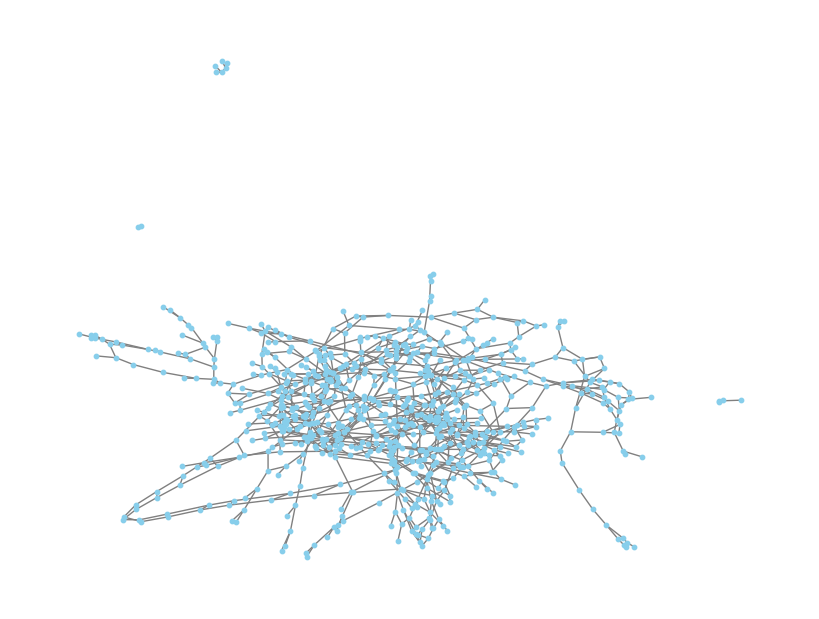

In [6]:
plt.figure(figsize=(8,6))
nx.draw(G_loaded[0], with_labels=False, node_color='skyblue', edge_color='gray', node_size=10)
plt.savefig("G48B_3_graph.png", dpi = 300)
plt.show()
